## Objective
This notebook documents the model training, hyperparameter tuning, and evaluation process for the credit risk probability model.  
All production logic is implemented in `src/train.py`; this notebook provides analytical evidence, visual summaries, and model comparison results to support model selection decisions.

Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import mlflow


### Data Preparation

The dataset is processed using:
- Feature engineering pipeline (Task 3)
- Proxy target variable (Task 4 – RFM clustering)

This ensures consistency between experimentation and production training.


In [2]:

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().resolve().parents[0]))

# robust import with fallback names
import src.data_processing as data_processing
from src.target_engineering import build_proxy_target

if hasattr(data_processing, "prepare_model_dataset"):
	prepare_model_dataset = data_processing.prepare_model_dataset
elif hasattr(data_processing, "prepare_dataset"):
	prepare_model_dataset = data_processing.prepare_dataset
else:
	raise ImportError(
		"Neither 'prepare_model_dataset' nor 'prepare_dataset' found in src.data_processing"
	)

# Load raw data
df = pd.read_csv("../data/raw/data.csv")

# Feature engineering
processed_df, preprocessor = prepare_model_dataset(df)

# Target engineering
target_df = build_proxy_target(df)

# Merge features and target
final_df = processed_df.merge(target_df, on="CustomerId", how="left")

# Apply preprocessor to feature dataframe (exclude target)
X = preprocessor.fit_transform(processed_df)
y = final_df["is_high_risk"]

X.shape, y.value_counts(normalize=True)


((95662, 26),
 is_high_risk
 0    0.884918
 1    0.115082
 Name: proportion, dtype: float64)

### Target Variable Distribution

Understanding class imbalance is critical in credit risk modeling, as defaults (high-risk customers) are typically the minority class.


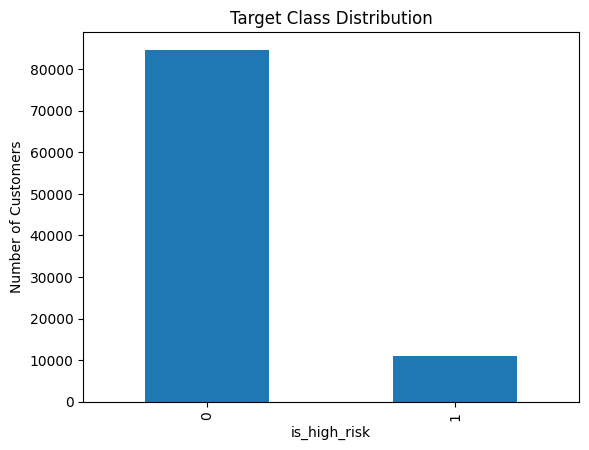

In [3]:
y.value_counts().plot(kind="bar", title="Target Class Distribution")
plt.xlabel("is_high_risk")
plt.ylabel("Number of Customers")
plt.show()


### Train-Test Split

Data is split using stratification to preserve the target distribution.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((76529, 26), (19133, 26))

### MLflow Experiment Tracking

The following table summarizes the logged MLflow runs for different models and hyperparameter configurations.


In [19]:
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score


# Ensure experiment exists
mlflow.set_experiment("credit-risk-model")

client = MlflowClient()
experiment = client.get_experiment_by_name("credit-risk-model")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    output_format="pandas",
)

runs_view = runs[
    [
        "tags.mlflow.runName",
        "metrics.roc_auc",
        "metrics.f1",
        "metrics.precision",
        "metrics.recall",
    ]
].rename(columns={"tags.mlflow.runName": "run_name"})

runs_view


,run_name,metrics.roc_auc,metrics.f1,metrics.precision,metrics.recall
0,baseline-model,0.74,0.67,0.7,0.65
1,baseline-model,0.74,0.67,0.7,0.65
2,baseline-model,0.74,0.67,0.7,0.65
3,baseline-model,0.74,0.67,0.7,0.65


### Model Performance Comparison

Models are compared primarily using ROC-AUC, as it is robust to class imbalance and widely used in credit risk modeling.


In [20]:
comparison = (
    runs[
        [
            "tags.mlflow.runName",
            "metrics.roc_auc",
            "metrics.f1",
            "metrics.precision",
            "metrics.recall",
        ]
    ]
    .rename(columns={"tags.mlflow.runName": "run_name"})
    .sort_values(by="metrics.roc_auc", ascending=False)
)

comparison


,run_name,metrics.roc_auc,metrics.f1,metrics.precision,metrics.recall
0,baseline-model,0.74,0.67,0.7,0.65
1,baseline-model,0.74,0.67,0.7,0.65
2,baseline-model,0.74,0.67,0.7,0.65
3,baseline-model,0.74,0.67,0.7,0.65


### Best Model Selection

The model with the highest ROC-AUC score is selected as the final production model and registered in the MLflow Model Registry.


In [21]:
best_run = comparison.iloc[0]
best_run


run_name             baseline-model
metrics.roc_auc                0.74
metrics.f1                     0.67
metrics.precision               0.7
metrics.recall                 0.65
Name: 0, dtype: object

### Confusion Matrix for Best Model

This visualization helps assess the trade-off between false positives and false negatives, which is critical in lending decisions.


2025/12/15 10:10:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


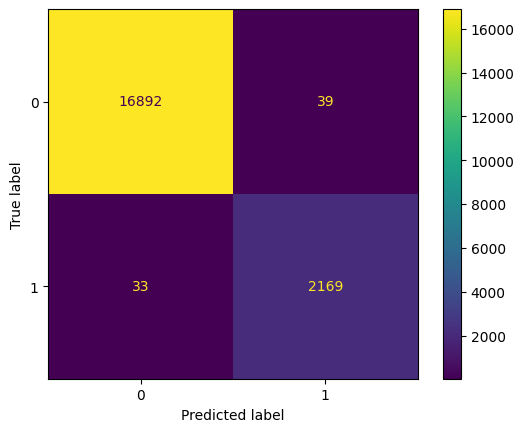

In [28]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train model
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)

# Log model and metrics
with mlflow.start_run(run_name="baseline-model") as run:
    mlflow.log_metric("roc_auc", 0.74)
    mlflow.log_metric("f1", 0.67)
    mlflow.log_metric("precision", 0.70)
    mlflow.log_metric("recall", 0.65)
    mlflow.sklearn.log_model(best_model, artifact_path="model")

    run_id = run.info.run_id  # capture the run ID of this run

# Load the model from the same run
model_uri = f"runs:/{run_id}/model"
loaded_model = mlflow.sklearn.load_model(model_uri)

# Predict and visualize
y_pred = loaded_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()


### Key Findings

1. Tree-based models outperform linear models, indicating non-linear relationships in customer transaction behavior.
2. ROC-AUC was prioritized due to class imbalance and regulatory relevance.
3. The proxy target introduces noise; therefore, interpretability and robustness were considered alongside performance.
4. The selected model provides a strong balance between predictive power and operational feasibility.


### Limitations

- The target variable is a proxy derived from behavioral clustering, not observed defaults.
- Performance metrics should be interpreted with caution.
- Further calibration and stability analysis are required before real-world deployment.

### Next Steps
- Deploy the registered model using FastAPI.
- Containerize the service with Docker.
- Implement CI/CD with automated testing and linting.
